## Energy module - basic functionality
In this notebook, we set up graph with a single edge to demonstrate some basic functionality of the Energy module.

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
from shapely.geometry import Point, LineString

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim
from opentnsim import core as core_module
from opentnsim import energy as energy_module
from opentnsim import graph as graph_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

import numpy as np
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt

### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _ConsumesEnergy_ - enables calculation of resistance, required power and emissions

In [2]:
#We create a type element that schematisizes a vessel
def create_vessel(env,
                  name,
                  origin, 
                  destination, 
                  vessel_type, 
                  L, 
                  B, 
                  T,
                  v,
                  P_tot_given,
                  C_year,
                  arrival_time):
    
    Vessel = type('Vessel',(energy_module.ConsumesEnergy,   # The vessel consumes energy
                            vessel_module.IsVessel,         # Basic information of the vessel
                           ),{})  
    
    vessel = Vessel(**{ "env": env,
                        "name": name,
                        "origin": origin,
                        "destination": destination,
                        "type": vessel_type,
                        "L": L,                     # m
                        "B": B,                     # m
                        "T": T,                     # m
                        "v": v,                     # m/s None: calculate this value based on P_tot_given
                        "safety_margin": 0.2,       # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
                        "h_squat": True,           # if consider the ship squatting while moving, set to True, otherwise set to False
                        "P_installed": 1750.0,      # kW
                        "P_tot_given": P_tot_given, # kW None: calculate this value based on speed
                        "bulbous_bow": False,       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
                        "P_hotel_perc": 0.05,
                        "P_hotel": None,            # None: calculate P_hotel from percentage
                        "x": 2,                     # number of propellers
                        "L_w": 3.0 ,
                        "C_B": 0.85,                # block coefficient 
                        "C_year": 1990,             # engine build year
                        "arrival_time": arrival_time,
                      }
                   )

    env.process(vessel.move())
    
    return vessel

### 2. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

For this example, we construct a network of 4 nodes linked by 3 edges. The edges are made bi-directional to allow for two-way traffic, which means that the graph in the end contains 6 edges.

In [3]:
FG = nx.DiGraph()

# specifiy nodes and edges
node_A = graph_module.Node(name='0',geometry=Point(0,0))
node_B = graph_module.Node(name='1',geometry=Point(0.8983,0))

edges = [(node_A,node_B)]

# create a graph object
depths = {"GeneralDepth": [6.0]}
FG = graph_module.DiGraph(edges=edges,edges_info=depths).graph

In [4]:
# collect node positions and labels
nodes = []
coordinates = []
labels = {}

for node in FG.nodes:
    nodes.append(node)
    coordinates.append([nx.get_node_attributes(FG, 'geometry')[node].x, nx.get_node_attributes(FG, 'geometry')[node].y])
    labels[node] = node
    
positions = dict(zip(nodes, coordinates))

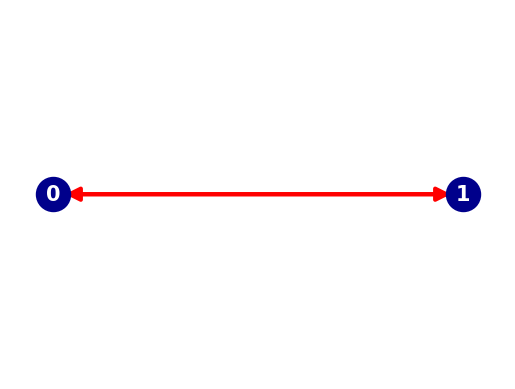

In [5]:
# draw edges, nodes and labels
nx.draw_networkx_edges(FG, pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG, pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight="bold", font_color="white")

plt.axis("off")
plt.show()

In [6]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('0', '1') is 6.0 m
General depth for edge ('1', '0') is 6.0 m


### 4. Run simulation
Now we can define the run. After we define the path that the vessel will sail, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [7]:
def create_run(FG,
               name,
               origin, 
               destination, 
               vessel_type, 
               L, 
               B, 
               T,
               v,
               P_tot_given, 
               C_year,
               arrival_time):
    
    # Start simpy environment
    t_start = datetime.datetime(2024, 1, 1, 0, 0, 0)
    
    env = simpy.Environment(initial_time=t_start.timestamp())
    
    env.epoch = t_start
    env.simulation_start = t_start
    
    # Add graph to environment
    env.FG = FG
    
    #In order from ships to know where they are going we need to add an VTS to the environment
    env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(env=env)

    # Create vessel
    vessel = create_vessel(env=env,
                           name='Vessel',
                           origin='0', 
                           destination='1', 
                           vessel_type='inland vessel', 
                           L=L,                         # m
                           B=B,                         # m 
                           T=T,                         # m
                           v=v,                         # m/s
                           P_tot_given=P_tot_given,     # kW 
                           C_year=C_year,               # engine construction year
                           arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))
    
    env.run()
    
    energycalculation = opentnsim.energy.EnergyCalculation(env.FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df['fuel_kg_per_km'] = (df['total_diesel_consumption_ICE_mass'] / 1000) / (df['distance']/1000)
    df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
    df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
    df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
    
    return df, vessel

### 4.1 Show the effects of vessel velocity on resistance, power and energy
We will now sail the same path with the same vessel at different speeds

In [8]:
# set the waterdepth (h_0) on the edge
FG.edges[('0', '1')]['Info']['GeneralDepth']=7.5
FG.edges[('1', '0')]['Info']['GeneralDepth']=7.5

# generate a range of vessel speeds
v_list = list(np.arange(0.1,5,.1))

# generate vessels that sail the edge for the given range of vessel speeds
dfs = []
vessels = []
for v in v_list:
    df, vessel = create_run(FG=FG,
                          name='Vessel',
                          origin='0', 
                          destination='1', 
                          vessel_type='inland vessel', 
                          L=135,                # m
                          B=11.45,              # m 
                          T=2.75,               # m
                          v=v,                  # m/s
                          P_tot_given=None,     # kW 
                          C_year=1990,          # engine construction year
                          arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))
    dfs.append(df)
    vessels.append(vessel)

In [9]:
# collect values to plot
R_tot=[]
R_f_one_k1=[] 
R_APP=[]
R_W=[]
R_res=[]
P_tot=[]
total_energy=[]
for index, df in enumerate(dfs):
    R_tot.append(vessels[index].R_tot)
    R_f_one_k1.append(vessels[index].R_f_one_k1)
    R_APP.append(vessels[index].R_APP)
    R_W.append(vessels[index].R_W)
    R_res.append(vessels[index].R_res)
    P_tot.append(df.P_tot.values[0])
    total_energy.append(df.total_energy.values[0])

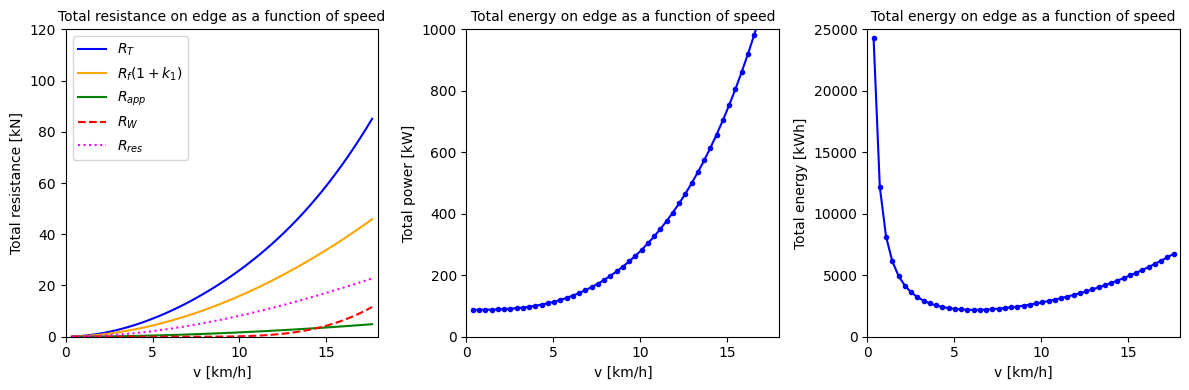

In [10]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

# plot resistance components as a function of vessel speed
axes[0].plot([i*3.6 for i in v_list], R_tot, '-',  c='blue', mfc='blue', mec='blue', markersize=3, label='$R_T$')
axes[0].plot([i*3.6 for i in v_list], R_f_one_k1, '-',  c='orange', mfc='orange', mec='orange', markersize=3, label='$R_f (1+k_1)$')
axes[0].plot([i*3.6 for i in v_list], R_APP, '-',  c='green', mfc='green', mec='green', markersize=3, label='$R_{app}$')
axes[0].plot([i*3.6 for i in v_list], R_W, '--',  c='red', mfc='red', mec='red', markersize=3, label='$R_W$')
axes[0].plot([i*3.6 for i in v_list], R_res, ':',  c='magenta', mfc='magenta', mec='magenta', markersize=3, label='$R_{res}$')

axes[0].axis([0,18,0,120])
axes[0].set_xlabel('v [km/h]');
axes[0].set_ylabel('Total resistance [kN]');
axes[0].set_title('Total resistance on edge as a function of speed', fontsize=10);
axes[0].legend(loc='upper left')
    
# plot total power needed to pass the edge as a function of vessel speed
axes[1].plot([i*3.6 for i in v_list], P_tot, '-o',  c='blue', mfc='blue', mec='blue', markersize=3)

axes[1].axis([0,18,0,1000])
axes[1].set_xlabel('v [km/h]');
axes[1].set_ylabel('Total power [kW]');
axes[1].set_title('Total energy on edge as a function of speed', fontsize=10);

# plot total energy needed to pass the edge as a function of vessel speed 
axes[2].plot([i*3.6 for i in v_list], total_energy, '-o',  c='blue', mfc='blue', mec='blue', markersize=3)

axes[2].axis([0,18,0,25000])
axes[2].set_xlabel('v [km/h]');
axes[2].set_ylabel('Total energy [kWh]');
axes[2].set_title('Total energy on edge as a function of speed', fontsize=10);

fig.tight_layout()

Panel 1 in the figure above, corresponds to Part IV - Figure 5.4 in Van Koningsveld et al (2023), https://doi.org/10.5074/T.2021.004. Panel 2 shows how the R_tot from Panel 1 is converted to P_tot, using various efficiency factors. Panel 3 shows the total energy that is required to pass the 100 km long edge. This total energy is derived by multiplying the P_tot with the time it takes to pass the edge. For very low v's the R_tot is low, but it also takes long to pass the edge. For high v's the R_tot escalates, but the time topass the edge reduces.

The 'steps' that can be noted in panels 2 and 3 in the above figure are due to the implementation of a varying hydrodynamic efficiency factor, as proposed by Simic et al (2013) "On Energy Efficiency of Inland Waterway Self-Propelled Cargo Vessels", https://www.researchgate.net/publication/269103117. This approach suggests a dynamic hydrodynamic efficiency factor based on the depth related Froude number, for a range of depth classes.

### 4.2 Show the effects of vessel velocity on emissions
We use the results from the previous section to show the effects of vessel velocities on emissions.

In [11]:
# collect values to plot
total_CO2=[]
total_NOx=[]
total_PM10=[]
for index, df in enumerate(dfs):
    total_CO2.append(df.CO2_g_per_km.values[0])
    total_NOx.append(df.NOx_g_per_km.values[0])
    total_PM10.append(df.PM10_g_per_km.values[0])

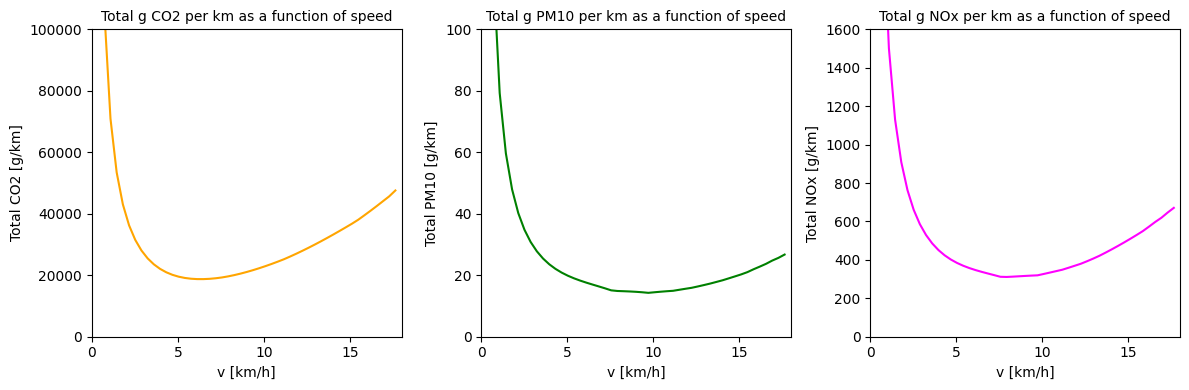

In [12]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

# plot the g CO2 per km as a function of vessel speed 
axes[0].plot([i*3.6 for i in v_list], total_CO2, '-',  c='orange')

axes[0].axis([0,18,0,100000])
axes[0].set_xlabel('v [km/h]');
axes[0].set_ylabel('Total CO2 [g/km]');
axes[0].set_title('Total g CO2 per km as a function of speed', fontsize=10);

# plot the g PM10 per km as a function of vessel speed 
axes[1].plot([i*3.6 for i in v_list], total_PM10, '-',  c='green')

axes[1].axis([0,18,0,100])
axes[1].set_xlabel('v [km/h]');
axes[1].set_ylabel('Total PM10 [g/km]');
axes[1].set_title('Total g PM10 per km as a function of speed', fontsize=10);

# plot the g NOx per km as a function of vessel speed 
axes[2].plot([i*3.6 for i in v_list], total_NOx, '-',  c='magenta')

axes[2].axis([0,18,0,1600])
axes[2].set_xlabel('v [km/h]');
axes[2].set_ylabel('Total NOx [g/km]');
axes[2].set_title('Total g NOx per km as a function of speed', fontsize=10);

fig.tight_layout()

The above figure, corresponds to Part IV - Figure 5.10 in Van Koningsveld et al (2023), https://doi.org/10.5074/T.2021.004. Panel 1 shows g/km emission of CO2 (the total CO2 emitted while passing the 100 km edge, divided by the length of the edge). Panel 2 shows the g/km emission of PM10. Panel 3 shows the g/km emission of NOx. The y-axes indicate emissions in g/km. The shape of the graph shows that for low speeds inefficient engine use combined with longer dwell time leads to higher emissions per unit distance. For higher speeds the increased resistance leads to higher emissions per unit distance. An optimum lies in between.

### 4.3 Show the effects of increasing engine power on vessel speed and emissions
We will now sail the same path with the same vessel at a given speed, and change the water depths in steps.

In [13]:
# set the waterdepth (h_0) on the edge
FG.edges[('0', '1')]['Info']['GeneralDepth']=7.5
FG.edges[('1', '0')]['Info']['GeneralDepth']=7.5

# generate a range of vessel speeds
P_tot_given_list = list(np.arange(100,1800,10))

# generate vessels that sail the edge for the given range of vessel speeds
dfs = []
vessels = []
for P_tot_given in P_tot_given_list:
    df, vessel = create_run(FG=FG,
                          name='Vessel',
                          origin='0', 
                          destination='1', 
                          vessel_type='inland vessel', 
                          L=135,                   # m
                          B=11.45,                 # m 
                          T=2.75,                  # m
                          v=None,                  # m/s
                          P_tot_given=P_tot_given, # kW 
                          C_year=1990,             # engine construction year
                          arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))
    dfs.append(df)
    vessels.append(vessel)

In [14]:
# collect values to plot
R_tot=[]
R_f_one_k1=[] 
R_APP=[]
R_W=[]
R_res=[]
P_tot=[]
total_energy=[]
v_list = []
v_power_given=[]
for index, df in enumerate(dfs):
    R_tot.append(vessels[index].R_tot)
    R_f_one_k1.append(vessels[index].R_f_one_k1)
    R_APP.append(vessels[index].R_APP)
    R_W.append(vessels[index].R_W)
    R_res.append(vessels[index].R_res)
    P_tot.append(df.P_tot.values[0])
    total_energy.append(df.total_energy.values[0])
    v_list.append(vessels[index].v)
    v_power_given.append(vessels[index].P_given)

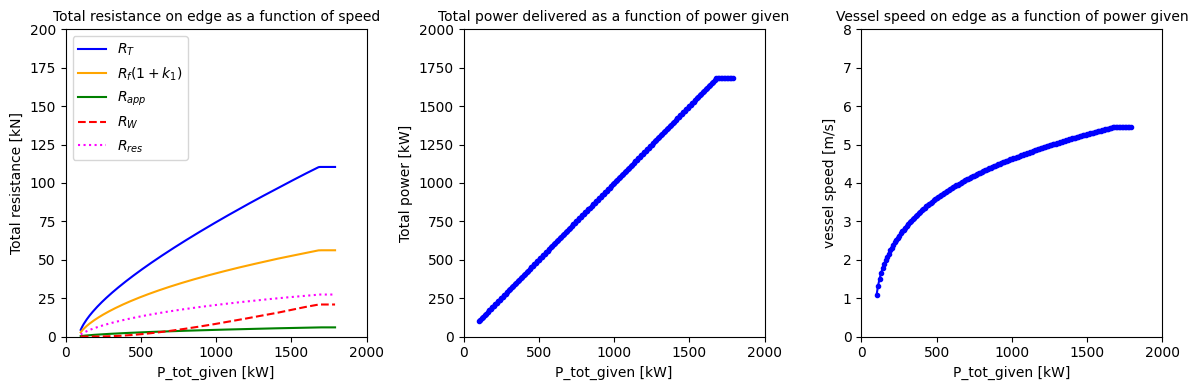

In [15]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

# plot resistance components as a function of vessel speed
axes[0].plot([i for i in P_tot_given_list], R_tot, '-',  c='blue', mfc='blue', mec='blue', markersize=3, label='$R_T$')
axes[0].plot([i for i in P_tot_given_list], R_f_one_k1, '-',  c='orange', mfc='orange', mec='orange', markersize=3, label='$R_f (1+k_1)$')
axes[0].plot([i for i in P_tot_given_list], R_APP, '-',  c='green', mfc='green', mec='green', markersize=3, label='$R_{app}$')
axes[0].plot([i for i in P_tot_given_list], R_W, '--',  c='red', mfc='red', mec='red', markersize=3, label='$R_W$')
axes[0].plot([i for i in P_tot_given_list], R_res, ':',  c='magenta', mfc='magenta', mec='magenta', markersize=3, label='$R_{res}$')

axes[0].axis([0,2000,0,200])
axes[0].set_xlabel('P_tot_given [kW]');
axes[0].set_ylabel('Total resistance [kN]');
axes[0].set_title('Total resistance on edge as a function of speed', fontsize=10);
axes[0].legend(loc='upper left')
    
# plot total power needed to pass the edge as a function of vessel speed
axes[1].plot([i for i in P_tot_given_list], v_power_given, '-o',  c='blue', mfc='blue', mec='blue', markersize=3)

axes[1].axis([0,2000,0,2000])
axes[1].set_xlabel('P_tot_given [kW]');
axes[1].set_ylabel('Total power [kW]');
axes[1].set_title('Total power delivered as a function of power given', fontsize=10);

# plot total energy needed to pass the edge as a function of vessel speed 
axes[2].plot([i for i in P_tot_given_list], v_list, '-o',  c='blue', mfc='blue', mec='blue', markersize=3)

axes[2].axis([0,2000,0,8])
axes[2].set_xlabel('P_tot_given [kW]');
axes[2].set_ylabel('vessel speed [m/s]');
axes[2].set_title('Vessel speed on edge as a function of power given', fontsize=10);

fig.tight_layout()

### 4.4 Show the effects of changing water depth (WIP)
We will now sail the same path with the same vessel at a given speed, and change the water depths in steps.

In [16]:
# generate a range of depths
depth_list = list(np.arange(4, 15, .1))

# generate vessels that sail the edge for the given range of vessel speeds
dfs = []
vessels = []
for depth in depth_list:
    FG.edges[('0', '1')]['Info']['GeneralDepth']=depth
    FG.edges[('1', '0')]['Info']['GeneralDepth']=depth
    
    df, vessel = create_run(FG=FG,
                          name='Vessel',
                          origin='0', 
                          destination='1', 
                          vessel_type='inland vessel', 
                          L=110,                # m
                          B=11.4,               # m 
                          T=3.5,                # m
                          v=3.0,                # m/s
                          P_tot_given=None,     # kW 
                          C_year=1990,          # engine construction year
                          arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))
    
    dfs.append(df)
    vessels.append(vessel)    

In [17]:
# collect values to plot
total_energy=[]
for index, df in enumerate(dfs):
    total_energy.append(df.total_energy.values[0])

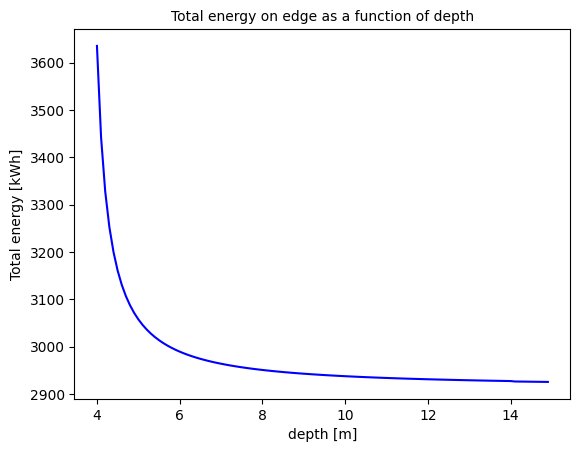

In [18]:
fig, axes = plt.subplots(1,1)

plt.plot(depth_list, total_energy, '-',  c='blue')

axes.set_xlabel('depth [m]');
axes.set_ylabel('Total energy [kWh]');
axes.set_title('Total energy on edge as a function of depth', fontsize=10);

In [19]:
v_list = list(np.arange(3,4,1))

# generate vessels that sail the edge for the given range of vessel speeds
dfs = []
for v in v_list:
    dfs.append(create_run(FG=FG,
                          name='Vessel',
                          origin='0', 
                          destination='1', 
                          vessel_type='inland vessel', 
                          L=110,                # m
                          B=11.4,               # m 
                          T=3.5,                # m
                          v=v,                  # m/s
                          P_tot_given=None,     # kW 
                          C_year=1990,
                          arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0)))

In [20]:
df, vessel = create_run(FG=FG,
                          name='Vessel',
                          origin='0', 
                          destination='1', 
                          vessel_type='inland vessel', 
                          L=110,                # m
                          B=11.4,               # m 
                          T=3.5,                # m
                          v=3,                  # m/s
                          P_tot_given=None,     # kW
                          C_year=1990,          # engine construction year
                          arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))

In [21]:
df = pd.DataFrame(vessel.logbook)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node 0 to node 1 start,2024-01-01 00:00:00.000000,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0 0)
1,Sailing from node 0 to node 1 stop,2024-01-01 09:15:32.766193,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.8983 0)
